### Не все так однозначно

**не порно**:
- Болезни опорно-двигательной системы и импотенция: взаимосвязь
- Транссексуальные рыбы - National Geographic Россия: красота мира в каждом кадре
- Групповая обзорная экскурсия по Афинам - цена €50
- Больного раком Задорнова затравили в соцсетях.
- Гомосексуалисты на «Первом канале»? Эрнст и Галкин – скрытая гей-пара российского шоу-бизнеса | Заметки о стиле, моде и жизни

**порно**:
- Отборная домашка
- Сюзанна - карьера горничной / Susanna cameriera perversa (с русским переводом) 1995 г., DVDRip

# ML baseline

In [255]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from scipy.sparse import hstack
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artrsyf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


## 1 Простое решение с использованием LabelEncoder для категориальных признаков:

Просто используем LabelEncoder для категориальных признаков и применяем логистическую регрессию

In [131]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

y_train = train_df["label"]
x_train = train_df.drop("label", axis=1)
x_test = test_df.copy()
le = LabelEncoder()
categorical_features = x_train.select_dtypes(include=[object]).columns.tolist()
for feature in categorical_features:
    x_train[feature] = le.fit_transform(x_train[feature])
    x_test[feature] = le.fit_transform(x_test[feature])
model = LogisticRegression()
model.fit(x_train, y_train)

print(classification_report(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
x_test["label"] = y_pred
x_test[["ID", "label"]].to_csv("simple_baseline.csv", index=False)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    118594
           1       0.00      0.00      0.00     16715

    accuracy                           0.88    135309
   macro avg       0.44      0.50      0.47    135309
weighted avg       0.77      0.88      0.82    135309



C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Из решения видно, что модель работает некорректно и определяет все значения к классу 0

## 2.1 Рассмотрим теперь распределение значений датасета 

array([118594,  16715], dtype=int64)

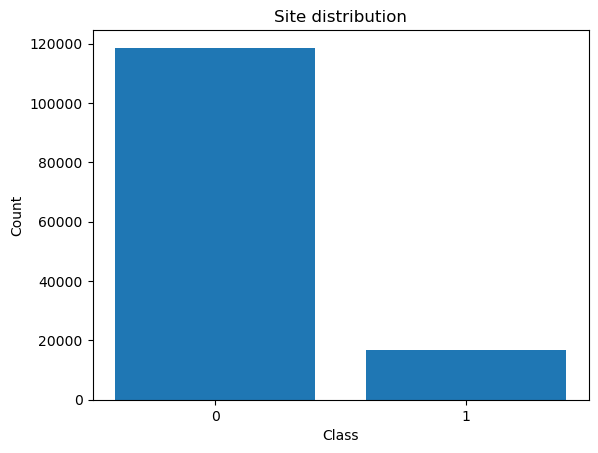

In [132]:
train_df["label"].unique() # Только значения 0 и 1
distribution_stats = train_df["label"].value_counts()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Site distribution")
plt.bar(x=['0', '1'], height=distribution_stats.values)
distribution_stats.values

Из диаграммы видим, что в датасете большой перекос в сторону не порнографических сайтов

## 2.2 Воспользуемся простым решением с TfidfVectorizer только для свойства title

In [216]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
num_features = tfidf_vectorizer.fit_transform(train_df['title'])

x_train, x_valid, y_train, y_valid = train_test_split(num_features, train_df["label"], test_size=0.25)

model = LogisticRegression()
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9142504626773597

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29672
           1       0.99      0.82      0.90      4155

    accuracy                           0.98     33827
   macro avg       0.98      0.91      0.94     33827
weighted avg       0.98      0.98      0.98     33827

[[29640    32]
 [  731  3424]]


Модель показала хороший результат, но виден перекос в предсказаниях в сторону класса 0. Чтобы это исправить, попробуем сбалансировать по классам датасет

In [217]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
num_features = tfidf_vectorizer.fit_transform(train_df['title'])

x_train, x_valid, y_train, y_valid = train_test_split(num_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9438922204879652

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29690
           1       0.96      0.93      0.95      4137

    accuracy                           0.99     33827
   macro avg       0.98      0.96      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29527   163]
 [  280  3857]]


Видно, что количество ошибок по классам +- уравнялось, результат модели также улучшился

Проверим также работу модели по фиче url

In [ ]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
url_features = tfidf_vectorizer.fit_transform(train_df['url'])

x_train, x_valid, y_train, y_valid = train_test_split(url_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['url']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.8335864612714254

Результат сильно упал, значит фича url менее информативная в сравнении с title

## 2.4 Попробуем теперь также применить и фичу url в обучении

В данном решении отдельно ставим в соответствие вектор для url и title. Далее эти вектора стекируем

In [235]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer1 = TfidfVectorizer()
tfidf_vectorizer2 = TfidfVectorizer()

title_features = tfidf_vectorizer1.fit_transform(train_df['title'])
url_features = tfidf_vectorizer2.fit_transform(train_df['url'])
combined_features = hstack([title_features, url_features])

x_train, x_valid, y_train, y_valid = train_test_split(combined_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

combined_test_result = hstack([tfidf_vectorizer1.transform(test_df['title']), tfidf_vectorizer2.transform(test_df['url'])])
y_pred = model.predict(combined_test_result)
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9351205583756346

(135308, 189852)
(135308, 35002)
(135308, 224854)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29627
           1       0.98      0.96      0.97      4200

    accuracy                           0.99     33827
   macro avg       0.99      0.98      0.98     33827
weighted avg       0.99      0.99      0.99     33827

[[29538    89]
 [  187  4013]]


Как видно из результата, стекирование эмбеддингов пользы не принесло. Скорее всего модель немного переобучилась из- за большого количества параметров

В данном решении просто используюм эмбеддинг для строки из url и title

In [239]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
url_features = tfidf_vectorizer.fit_transform(train_df['title'] + train_df['url'])

x_train, x_valid, y_train, y_valid = train_test_split(url_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title'] + test_df['url']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9352861577648651

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29696
           1       0.95      0.95      0.95      4131

    accuracy                           0.99     33827
   macro avg       0.97      0.97      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29490   206]
 [  226  3905]]


Улучшения результата это также не принесло

## 3.1 Решенеи с использованием TfidfVectorizer для url и CountVectorizer для title

CountVectorizer - хорошее решение для title, т.к. title легко разбить на слова, а также можно выкинуть стоп-слова.
<br>
Для url оставим TfidfVectorizer
<br>
Также в данной функции в зависимости от параметра validation либо используется валидационная выборка с анализом результатов, либо нет

In [319]:
def predictPipeline(train_path, test_path, target, validation=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(), "url"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9573121246550884

predictPipeline("train.csv", "test.csv", "label")

C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң

Попробуем отредактировать параметр url и сделать его более информативным.
<br>
Для этого оставим только доменное имя сайта, чтобы модель не искала взаимосвязей ...

В итоге получаем улучшение скора

In [318]:
result_df = predictPipeline("train.csv", "test.csv", "label", validation=True)
incorrect_predictions = result_df[(result_df['true_label'] != result_df['predicted_label'])]
incorrect_predictions

C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     29683
           1       0.94      0.96      0.95      4144

    accuracy                           0.99     33827
   macro avg       0.97      0.98      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29423   260]
 [  147  3997]]


,url,title,true_label,predicted_label
3397,grandcapital.net,Private Office — The account has been created!,0,1
59112,11r3.furs-udekasi.ru,Шоколадка hd порноСупер ебля - 11r3.furs-udeka...,1,0
45123,lemurov.net,"Муж бросил жену, но после того как над ее внеш...",0,1
40670,m.ednews.net,Həbib Nurməhəmmədovdan məğlub etdiyi rəqibinə ...,0,1
23449,examchemistry.com,Спирты,0,1
...,...,...,...,...
52675,invalidy.com,Всі пільги інвалідам 2 групи відомі? —,0,1
15336,gigapeta.com,GigaPeta.com,0,1
99060,autocart.biz,Royal enfield interceptor Photo and Video Revi...,0,1
105746,svs-games.com,Jane - The Office Slut,1,0


In [322]:
import tldextract

def extract_domain(url):
    return tldextract.extract(url).domain

def predictPipelineWithExtractedDomain(train_path, test_path, target, validation=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(), "domain"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)
    test_df['domain'] = test_df['url'].apply(extract_domain)
    train_df['domain'] = train_df['url'].apply(extract_domain)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9724997935419936

predictPipelineWithExtractedDomain("train.csv", "test.csv", "label")

C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң

In [320]:
def ensemble(X, y, x_res, fold_number: int = 2, model=LogisticRegression()):
    kf = KFold(n_splits=fold_number, shuffle=True, random_state=42)
    a = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(x_res)
        a.append(probabilities)
    y_pred = (np.mean(a, axis=0)[:, 1] > 0.5).astype(int)
    return y_pred


transformer = ColumnTransformer([
    ("tfidf", TfidfVectorizer(), "url"),
    ("count", CountVectorizer(stop_words=stop_words), "title"),
])
pipeline = Pipeline([
    ("preprocessor", transformer),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
])

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

x_train = train_df
y_train = train_df["label"]
del x_train["label"]
del x_train["ID"]

y_pred = ensemble(x_train, y_train, test_df, 25, pipeline)

test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9569875020288914

C:\dev\miniconda\envs\ds\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаң